#### 导入程序中需要用到的包：包括$networkx$-复杂网络包，$numpy$-数字$python$，$pandas$-数据处理包，$matplotlib.pyplot$-作图包

In [1]:
%matplotlib inline
from __future__ import division
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import copy
import time
import csv

#### 按照个体间信念交互的扩散函数

个体在未开通支付宝一卡通之前，通过与广告、已采纳邻居的交谈以及观察邻居的使用行为更新自己的信念，直至某一刻开通服务。在开通支付宝一卡通之后，个体通过自己的使用经验更新信念，即支付宝一卡通的便利性和实际有用性，进而决定是否持续使用支付宝一卡通作为充值的途径。因此，在此应区别对待开通服务群里和未开通服务群体的采纳模型：对于未开通服务群体，通过邻居影响更新信念，进而决定是否采纳；对于开通服务群体，通过使用行为更新信念，即实际使用体验影响各种观念。

初始时刻，假定所有个体的观念都是中性的，即为0.5。群体中未出现采纳者，邻居之间无相互影响，但会受到广告的影响。其中一些比较有创新意识的个体将采纳创新，这部分个体对该创新有较高期待，即高于0.5。当这部分个体采纳创新之后，他们获取了关于创新的实际使用经验，此时各种信念也相应得到更新，信念的性质由实际使用经验决定。根据实际体验，这些已采纳个体决定是否持续使用创新及向邻居传递何种信念（正向信念>0.5，负向信念<0.5）。                                                                                                                                           
具体实现：（1）初始时刻，所以节点含有感知有用、感知易用和使用意向等信念，且各信念值均为0.5；（2）广告进入群体，一部分个体将受此影响更新信念，当信念达到一定值时，采纳创新；（3）这部分个体将获取直接使用经验，进而更新信念且传播信念；（4）未采纳群体受广告和采纳群体的影响更新信念。
参数：（1）影响者和跟随者比例；（2）已使用者观念的分布；（3）广告影响和邻居影响比例系数

 节点$i$的信念更新规则：$Y_{i,t+1}=\frac{elast\cdot Y_{i,0}+\sum_{j \in N_i}s_{j,t}\cdot Y_{j,t}}{elast+\sum_{j \in N_i}s_{j,t}}$，其中$N_i$为$i$的邻居集合。各节点的初始信念值为0.5，状态值为0。初始时刻，如果个体为意见领袖，则会受到广告影响，从而按概率p更新采纳状态。采纳之后，个体将根据自己的体验重新生成信念值，信念值从样本中的已采纳部分随机获取。

In [2]:
def _update_belief_(DG,F_DG,non_adopt_nodes,i,p,q,para_cont):
    if DG[i]['type'] == 1:
        prm = para_cont[0]
    else:
        prm = para_cont[1]
    
    x = np.sum([F_DG[j]['state'] for j in F_DG[i]['prede']])
    for bl in ['pu','att','peou']:
        y = np.sum([F_DG[j]['state']*F_DG[j][bl] for j in F_DG[i]['prede']]) #上一周期信念均值       
        DG[i][bl] = (DG[i]['elast']*0.5 + y)/(DG[i]['elast']+x) #0.5为初始信念值
        
    DG[i]['pu'] = DG[i]['pu'] + prm[0]*(DG[i]['peou'] - F_DG[i]['peou'])                                               
    DG[i]['att'] = DG[i]['att'] + prm[1]*(DG[i]['peou'] - F_DG[i]['peou'])                                               
    DG[i]['ui'] = DG[i]['ui'] + prm[2]*(DG[i]['pu'] - F_DG[i]['pu'])+ prm[3]*(DG[i]['att'] - F_DG[i]['att'])
    
    if DG[i]['type']*p + (DG[i]['ui']-0.5)*q > np.random.random():
        idx = np.random.randint(prm[4])
        if DG[i]['type']==1:
            DG[i]['peou'] = max(0,min(1,OL_ad['peou'][idx]+0.1*np.random.randn()))
            DG[i]['pu'] = max(0,min(1,OL_ad['pu'][idx]+0.1*np.random.randn()))
            DG[i]['att'] = max(0,min(1,OL_ad['att'][idx]+0.1*np.random.randn()))
            DG[i]['ui'] = max(0,min(1,OL_ad['ui'][idx]+0.1*np.random.randn()))
            
        else:
            DG[i]['peou'] = max(0,min(1,FL_ad['peou'][idx]+0.1*np.random.randn()))
            DG[i]['pu'] = max(0,min(1,FL_ad['pu'][idx]+0.1*np.random.randn()))
            DG[i]['att'] = max(0,min(1,FL_ad['att'][idx]+0.1*np.random.randn()))
            DG[i]['ui'] = max(0,min(1,FL_ad['ui'][idx]+0.1*np.random.randn()))
        
        DG[i]['state'] = 1
        non_adopt_nodes.remove(i)

#### 扩散过程：记录各时刻的信念均值和方差，以及累计扩散率。

In [3]:
def _diffuse_(DG,num_of_run,p,q,param_cont):
    temp = []
    for x in ['pu','peou','att','ui']:
        attr_list = [DG[i][x] for i in DG.nodes()]
        temp.extend([np.mean(attr_list),np.std(attr_list)])
        
    stat_data = pd.DataFrame({'pu_mean':[temp[0]],'pu_std':[temp[1]],'peou_mean':[temp[2]],'peou_std':[temp[3]],
                              'att_mean':[temp[4]],'att_std':[temp[5]],'ui_mean':[temp[6]],'ui_std':[temp[7]],
                              'cumadrate':[sum([DG[i]['state'] for i in DG.nodes()])/m]})
    
    j = 1
    non_adopt_nodes = [i for i in DG.nodes() if DG[i]['state']==0]
    while 1:
        F_DG = copy.deepcopy(DG)
        for i in non_adopt_nodes:
            _update_belief_(DG,F_DG,non_adopt_nodes,i,p,q,param_cont)       
        temp = []
        for x in ['pu','peou','att','ui']:
            attr_list = [DG[i][x] for i in DG.nodes()]
            temp.extend([np.mean(attr_list),np.std(attr_list)])  
            
        stat_temp = pd.DataFrame({'pu_mean':[temp[0]],'pu_std':[temp[1]],'peou_mean':[temp[2]],'peou_std':[temp[3]],
                              'att_mean':[temp[4]],'att_std':[temp[5]],'ui_mean':[temp[6]],'ui_std':[temp[7]],
                              'cumadrate':[sum([DG[i]['state'] for i in DG.nodes()])/m ]})
        
        stat_data = pd.concat([stat_data,stat_temp], ignore_index=True)
        j = j+1
        if j > num_of_run:
            break
    
    return stat_data

导入数据

s_data为样本数据，s_data中的变量包括：pu,peou,att,ui,type,state。注意按系统路径导入CSV文件

In [4]:
s_data = pd.read_csv('/Users/xiaoyu/Documents/sum.csv')
grouped = s_data.groupby(['type','state'])
OL_ad = grouped.get_group((1,1)) 
FL_ad = grouped.get_group((0,1))
OL_ad.index = np.arange(len(OL_ad))
FL_ad.index = np.arange(len(FL_ad))

OL_len = len(OL_ad)
FL_len = len(FL_ad)
param_cont = [(0.797,0.535,0.248,0.463,OL_len),(0.05,0.522,0.663,0.566,FL_len)] #未采纳者信念之间的影响系数

程序运行

In [5]:
steps = 50 #扩散步数
repetes = 4 #扩散重复次数

a = 1 #跟随者信念弹性
b = 4 #意见领袖信念弹性
ratio = 0.838 #跟随者比例

p = 0.01 #广告影响权重
q = 1 #邻居影响权重
m = 1000 #网络节点数
data_cont = []

k = 1
while 1:
    time1 = time.clock()
    G = nx.watts_strogatz_graph(m,10,p=0) #nx.gnm_random_graph(m,5*m) #生成图
    DG = G.to_directed()
    type_random = np.random.random(m) 
    type_list = np.array(type_random > ratio,dtype = np.int) #如果type_random[i]大于ratio，则类型为影响者
    for i in DG.nodes():
        DG[i]['type'] = type_list[i]
        DG[i]['prede'] = DG.predecessors(i)
        DG[i]['state'] = 0
        if DG[i]['type'] == 1:
            DG[i]['elast'] = a
        else:
            DG[i]['elast'] = b
            
        for x in ['ui','pu','att','peou']: #分配初始属性值，均为0.5，即中性信念
            DG[i][x] = 0.5        
    
    diff_stat_data = _diffuse_(DG,steps,p,q,param_cont)    
    print u'第',k,u'次循环'
    print u'一共用时:',time.clock()-time1
    data_cont.append(diff_stat_data)
    k = k+1
    if k > repetes:
        break

第 1 次循环
一共用时: 15.715457
第 2 次循环
一共用时: 13.021634
第 3 次循环
一共用时: 14.218366
第 4 次循环
一共用时: 15.038108


In [10]:
mean_data = sum(data_cont)/len(data_cont)
adrate = [mean_data.cumadrate[0]] #求各时间点增加的采纳个体数
adrate.extend([mean_data.cumadrate[i]-mean_data.cumadrate[i-1] for i in range(1,len(mean_data))])

In [12]:
len(adrate)

51

数据整理和绘图

In [426]:
mean_data = sum(data_cont)/len(data_cont) #求扩散均值
adrate = [mean_data.cumadrate[0]] #求各时间点增加的采纳个体数
adrate.extend([mean_data.cumadrate[i]-mean_data.cumadrate[i-1] for i in range(1,len(mean_data))])
to_join = pd.DataFrame({'adrate':adrate})
mean_data = mean_data.join(to_join)
mean_data.to_csv('/Users/xiaoyu/Documents/belief update/'+DG.name+'.csv') #把数据写入csv文件，路径名根据自己的电脑文件夹设置

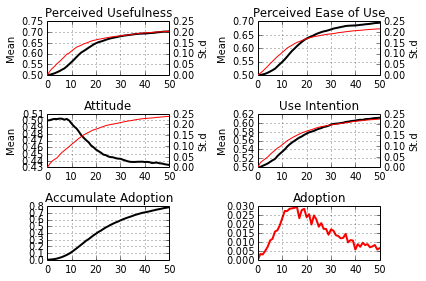

In [475]:
fig,axes = plt.subplots(nrows=3, ncols=2)
mean_data.pu_mean.plot(ax=axes[0,0],color = 'k',linewidth = 2)
mean_data.pu_std.plot(ax=axes[0,0],color = 'r',secondary_y = True,mark_right=False)
axes[0,0].set_title('Perceived Usefulness',fontsize = 12)
axes[0,0].set_ylabel('Mean')
axes[0,0].right_ax.set_ylabel('St.d')

mean_data.peou_mean.plot(ax=axes[0,1],color = 'k',linewidth = 2)
mean_data.peou_std.plot(ax=axes[0,1],secondary_y = True,color = 'r')
axes[0,1].set_title('Perceived Ease of Use',fontsize = 12)
axes[0,1].set_ylabel('Mean')
axes[0,1].right_ax.set_ylabel('St.d')

mean_data.att_mean.plot(ax=axes[1,0],color = 'k',linewidth = 2)
mean_data.att_std.plot(ax=axes[1,0],secondary_y = True,color = 'r')
axes[1,0].set_title('Attitude',fontsize = 12)
axes[1,0].set_ylabel('Mean')
axes[1,0].right_ax.set_ylabel('St.d')

mean_data.ui_mean.plot(ax=axes[1,1],color = 'k',linewidth = 2)
mean_data.ui_std.plot(ax=axes[1,1],secondary_y = True,color = 'r')
axes[1,1].set_title('Use Intention',fontsize = 12)
axes[1,1].set_ylabel('Mean')
axes[1,1].right_ax.set_ylabel('St.d')

mean_data.cumadrate.plot(ax=axes[2,0],color = 'k',linewidth = 2)
axes[2,0].set_title('Accumulate Adoption',fontsize = 12)

mean_data.adrate.plot(ax=axes[2,1],color = 'r',linewidth = 2)
axes[2,1].set_title('Adoption',fontsize = 12)

plt.grid(False)
plt.tight_layout()
plt.show()

In [487]:
fig2 = plt.figure(figsize=(8,8))
ax1 = fig2.add_subplot(1,2,1)
ax1.plot(np.arange(51),mean_data.cumadrate,color = 'ko-',linewidth = 2,label = 'accumulated')
ax1.set_title('Accumulate Adoption',fontsize = 12)
ax1.set_xlabel(r'$time$',fontsize = 12)

plt.grid(False)
plt.tight_layout()
plt.close()

In [484]:
fig2 = plt.figure(figsize=(8,8))
ax1 = fig2.add_subplot(1,2,1)
ax1.plot(np.arange(51),mean_data.cumadrate,color = 'ko-',linewidth = 2,label = 'accumulated')
ax1.set_title('Accumulate Adoption',fontsize = 12)
ax1.set_xlabel(r'$time$',fontsize = 12)

ax2 = fig2.add_subplot(1,2,2)
ax2.plot(np.arange(51),mean_data.adrate,color = 'ro-',linewidth = 2,label='temporal')
ax2.set_title('Temporal Adoption',fontsize = 12)
ax2.set_xlabel(r'$time$',fontsize = 12)

plt.grid(False)
plt.tight_layout()
plt.show()

#### 数据分析，研究问题:利用以上程序研究决策规则、参数或者网络结构对扩散过程的影响，扩散过程包括：观念的变化和采纳率的变化

（1）影响者和跟随者信念弹性的影响：变动参数a和b，对比累积扩散率和各时刻采纳率曲线

In [26]:
steps = 50 #扩散步数
repetes = 10 #扩散重复次数
a,b = 1,4
a_cont = [1,2,3,4,5,6]
b_cont = [1,2,3,4,5,6]

ratio = 0.838 #跟随者比例

p = 0.01 #广告影响权重
q = 1 #邻居影响权重
m = 1000 #网络节点数
diff_cont = []

for b in b_cont:
    k = 1
    data_cont = []
    time1 = time.clock()
    while 1:
        G = nx.gnm_random_graph(m,5*m) 
        DG = G.to_directed()
        type_random = np.random.random(m) 
        type_list = np.array(type_random > ratio,dtype = np.int) #如果type_random[i]大于ratio，则类型为影响者
        for i in DG.nodes():
            DG[i]['type'] = type_list[i]
            DG[i]['prede'] = DG.predecessors(i)
            DG[i]['state'] = 0
            if DG[i]['type'] == 1:
                DG[i]['elast'] = a
            else:
                DG[i]['elast'] = b

            for x in ['ui','pu','att','peou']: #分配初始属性值，均为0.5，即中性信念
                DG[i][x] = 0.5        

        diff_stat_data = _diffuse_(DG,steps,p,q,param_cont)    
        data_cont.append(diff_stat_data)
        k = k+1
        if k > repetes:
            break
    
    print (a,b),
    print u'一共用时:',time.clock()-time1
    
    mean_data = sum(data_cont)/len(data_cont)
    cumadrate = [mean_data.cumadrate[i] for i in range(steps+1)]
    adrate = [cumadrate[0]]
    adrate.extend([cumadrate[i] - cumadrate[i-1] for i in range(1,len(mean_data))])
    diff_cont.append([cumadrate,adrate]) 

(1, 1) 一共用时: 112.508071
(1, 2) 一共用时: 109.677561
(1, 3) 一共用时: 123.10194
(1, 4) 一共用时: 130.93765
(1, 5) 一共用时: 128.693672
(1, 6) 一共用时: 125.091645


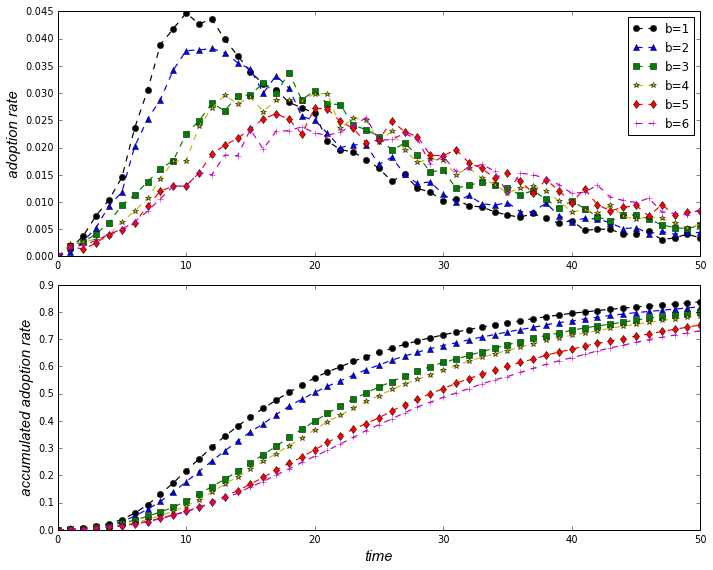

In [27]:
colr_cont = ['ko--','b^--','gs--','y*--','rd--','m+--']

fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
i = 0
for x in diff_cont:
    ax2.plot(np.arange(51),x[0],'%s'%colr_cont[i],linewidth = 1.2,label = 'b=%s'%a_cont[i])
    ax1.plot(np.arange(51),x[1],'%s'%colr_cont[i],linewidth = 1.2,label = 'b=%s'%a_cont[i])
    i = i+1

ax2.set_xlabel('time',style='italic',fontsize = 15)
ax1.set_ylabel('adoption rate',style='italic',fontsize = 15)
ax2.set_ylabel('accumulated adoption rate',style='italic',fontsize = 15)


ax1.legend(loc = 'best')
plt.tight_layout()   

（2）广告与邻居影响：变动广告影响权重p和邻居影响权重q，对比累积扩散率和各时刻采纳率曲线

In [37]:
steps = 50 #扩散步数
repetes = 10 #扩散重复次数
a = 1 #跟随者信念弹性
b = 4 #意见领袖信念弹性
ratio = 0.838 #跟随者比例

p = 0.01
q = 1 #邻居影响权重

p_cont = [0.01,0.02,0.03,0.04,0.05,0.06] #广告影响权重
q_cont = [0.6,0.8,1,1.2,1.4,1.6]
m = 1000 #网络节点数
diff_cont = []

for q in q_cont:
    k = 1
    data_cont = []
    time1 = time.clock()
    while 1:
        G = nx.gnm_random_graph(m,5*m) 
        DG = G.to_directed()
        type_random = np.random.random(m) 
        type_list = np.array(type_random > ratio,dtype = np.int) #如果type_random[i]大于ratio，则类型为影响者
        for i in DG.nodes():
            DG[i]['type'] = type_list[i]
            DG[i]['prede'] = DG.predecessors(i)
            DG[i]['state'] = 0
            if DG[i]['type'] == 1:
                DG[i]['elast'] = a
            else:
                DG[i]['elast'] = b

            for x in ['ui','pu','att','peou']: #分配初始属性值，均为0.5，即中性信念
                DG[i][x] = 0.5        

        diff_stat_data = _diffuse_(DG,steps,p,q,param_cont)    
        data_cont.append(diff_stat_data)
        k = k+1
        if k > repetes:
            break
    
    print (p,q),
    print u'一共用时:',time.clock()-time1
    
    mean_data = sum(data_cont)/len(data_cont)
    cumadrate = [mean_data.cumadrate[i] for i in range(steps+1)]
    adrate = [cumadrate[0]]
    adrate.extend([cumadrate[i] - cumadrate[i-1] for i in range(1,len(mean_data))])
    diff_cont.append([cumadrate,adrate]) 

(0.01, 0.6) 一共用时: 137.884825
(0.01, 0.8) 一共用时: 120.980998
(0.01, 1) 一共用时: 116.476042
(0.01, 1.2) 一共用时: 111.394111
(0.01, 1.4) 一共用时: 107.625462
(0.01, 1.6) 一共用时: 104.662336


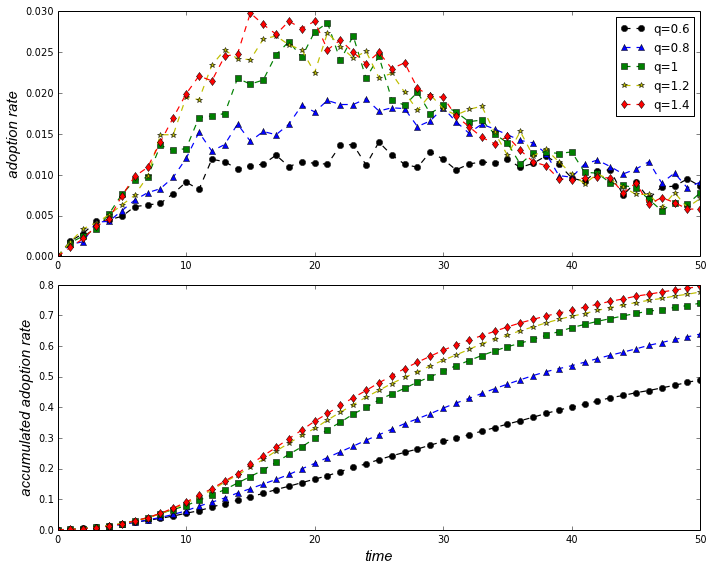

In [43]:
colr_cont = ['ko--','b^--','gs--','y*--','rd--','m+--']

fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
i = 0
for x in diff_cont:
    ax2.plot(np.arange(51),x[0],'%s'%colr_cont[i],linewidth = 1.2,label = 'q=%s'%q_cont[i])
    ax1.plot(np.arange(51),x[1],'%s'%colr_cont[i],linewidth = 1.2,label = 'q=%s'%q_cont[i])
    i = i+1

ax2.set_xlabel('time',style='italic',fontsize = 15)
ax1.set_ylabel('adoption rate',style='italic',fontsize = 15)
ax2.set_ylabel('accumulated adoption rate',style='italic',fontsize = 15)

ax1.legend(loc = 'best')
plt.tight_layout()  

（3）网络结构的影响：WS小世界网络，BA偏好连接网络，规则网络，二项分布网络（假定有相同的平均邻居数，以对比拓扑结构的影响）

In [41]:
steps = 50 #扩散步数
repetes = 10 #扩散重复次数
a = 1 #跟随者信念弹性
b = 4 #意见领袖信念弹性
ratio = 0.838 #跟随者比例

p = 0.01
q = 1 #邻居影响权重

m = 1000 #网络节点数
G_set = [nx.gnm_random_graph(m,5*m),nx.watts_strogatz_graph(m,10,p=0),nx.barabasi_albert_graph(m,5)]
G_set2 = [nx.watts_strogatz_graph(m,10,p=0),nx.watts_strogatz_graph(m,10,p=0.1),nx.watts_strogatz_graph(m,10,p=0.3),
          nx.watts_strogatz_graph(m,10,p=0.5),nx.watts_strogatz_graph(m,10,p=0.7)]

diff_cont = []

for G in G_set2:
    k = 1
    data_cont = []
    time1 = time.clock()
    while 1:
        #G = nx.gnm_random_graph(m,5*m) 
        DG = G.to_directed()
        type_random = np.random.random(m) 
        type_list = np.array(type_random > ratio,dtype = np.int) #如果type_random[i]大于ratio，则类型为影响者
        for i in DG.nodes():
            DG[i]['type'] = type_list[i]
            DG[i]['prede'] = DG.predecessors(i)
            DG[i]['state'] = 0
            if DG[i]['type'] == 1:
                DG[i]['elast'] = a
            else:
                DG[i]['elast'] = b

            for x in ['ui','pu','att','peou']: #分配初始属性值，均为0.5，即中性信念
                DG[i][x] = 0.5        

        diff_stat_data = _diffuse_(DG,steps,p,q,param_cont)    
        data_cont.append(diff_stat_data)
        k = k+1
        if k > repetes:
            break
    
    print (a,b),
    print u'一共用时:',time.clock()-time1
    
    mean_data = sum(data_cont)/len(data_cont)
    cumadrate = [mean_data.cumadrate[i] for i in range(steps+1)]
    adrate = [cumadrate[0]]
    adrate.extend([cumadrate[i] - cumadrate[i-1] for i in range(1,len(mean_data))])
    diff_cont.append([cumadrate,adrate]) 

(1, 4) 一共用时: 138.389579
(1, 4) 一共用时: 126.541728
(1, 4) 一共用时: 119.336333
(1, 4) 一共用时: 117.652589
(1, 4) 一共用时: 116.048865


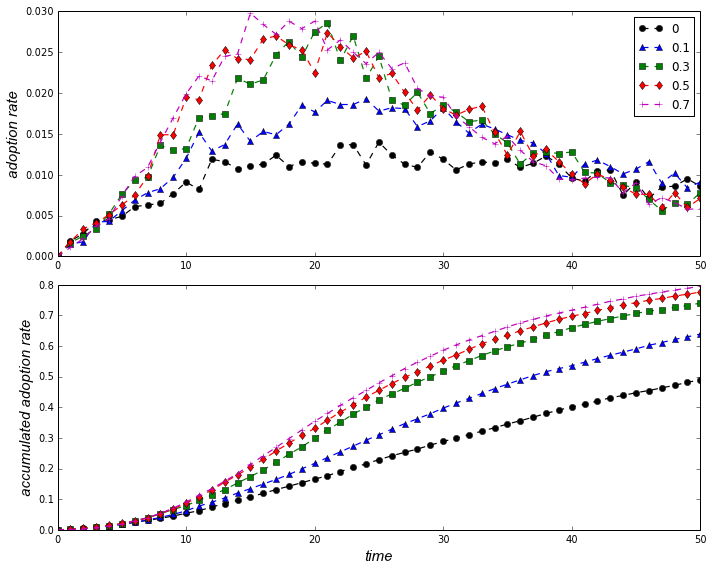

In [42]:
colr_cont = ['ko--','b^--','gs--','rd--','m+--']
labl_cont = ['ER','WS','BA']
labl_cont2 = [0,0.1,0.3,0.5,0.7]

fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
i = 0
for x in diff_cont:
    ax2.plot(np.arange(51),x[0],'%s'%colr_cont[i],linewidth = 1.2,label = '%s'%labl_cont2[i])
    ax1.plot(np.arange(51),x[1],'%s'%colr_cont[i],linewidth = 1.2,label = '%s'%labl_cont2[i])
    i = i+1

ax2.set_xlabel('time',style='italic',fontsize = 15)
ax1.set_ylabel('adoption rate',style='italic',fontsize = 15)
ax2.set_ylabel('accumulated adoption rate',style='italic',fontsize = 15)

ax1.legend(loc = 'best')
plt.tight_layout()  